# Preprocessing of CASIA-FASD Dataset for our Volumetric CNN Model.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install gdown -q
!gdown 1q5DlO2cu43sxdOTVyp0W43IaqorikqC9
!gdown 1H9sg0daYdvMB7_F1o7g70fbla1PmVVq4
!gdown 1dEOIB10Q9UgOdzbb_ed_ad7egmNiURi0
!mkdir DB
# !gdown 1LIGmaUMsFOnQahe5hi5rRyeWCJEsX6vT
# !gdown 1LomiNJxNeNJ6W5KIH8GaeuhlJwvnqtTw
# !cp /content/drive/MyDrive/CASIA_FASD.rar /content/CASIA_FASD.rar

Downloading...
From: https://drive.google.com/uc?id=1q5DlO2cu43sxdOTVyp0W43IaqorikqC9
To: /kaggle/working/CASIA_FASD.rar
100%|█████████████████████████████████████████| 876M/876M [00:03<00:00, 254MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H9sg0daYdvMB7_F1o7g70fbla1PmVVq4
To: /kaggle/working/deploy.prototxt.txt
100%|██████████████████████████████████████| 28.1k/28.1k [00:00<00:00, 17.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dEOIB10Q9UgOdzbb_ed_ad7egmNiURi0
To: /kaggle/working/res10_300x300_ssd_iter_140000.caffemodel
100%|███████████████████████████████████████| 10.7M/10.7M [00:00<00:00, 181MB/s]


In [3]:
%%capture
# !apt-get install unp
!apt-get install unrar
!mkdir 'CASIA_FASD'
!unrar x 'CASIA_FASD.rar' 'CASIA_FASD' -y

In [4]:
# from IPython.display import FileLink, FileLinks
# FileLinks('./CASIA_FASD/test_release/13')

In [5]:
import cv2
import numpy as np
from scipy import signal
import video_face_utils as futils
modelFile = "res10_300x300_ssd_iter_140000.caffemodel"
configFile = "deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

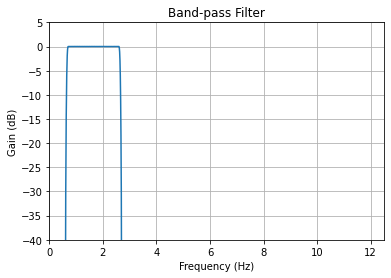

In [6]:
def plot_response(fs, w, h, title):

    "Utility function to plot response functions"

    fig = plt.figure()

    ax = fig.add_subplot(111)

    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))

    ax.set_ylim(-40, 5)

    ax.set_xlim(0, 0.5*fs)

    ax.grid(True)

    ax.set_xlabel('Frequency (Hz)')

    ax.set_ylabel('Gain (dB)')

    ax.set_title(title)
taps = futils.bp_eqrple_filt(fs=25)
w, h = signal.freqz(taps, [1], worN=2000)
import matplotlib.pyplot as plt
plot_response(25, w, h, "Band-pass Filter")

In [7]:
# %debug
import os
import gc
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from csv import writer
# from itertools import chain
import re
c = tqdm(range(600))
count = 0 
disp = np.random.randint(8,16)
for subdir, dirs, files in os.walk('CASIA_FASD'):
    for file in files:
        path = os.path.join(subdir,file)    
        is_HR = 'HR_' in path

        
        is_train = 'train' in path

        video = futils.read_vid(path)
        
        fc = video.shape[0]
        video = futils.detect_vid_wrapper(video[1:-1], net, 0.5, dims=(100, 100),bbox_exp = 0.5,fill = 'reflect')
        if video.shape[0] == 0 or video is None:
            with open('no_faces.txt', 'a',) as f:  
                f.write(f'{path}: {video}\n')
            continue
        temp = []
        for frame in video:
            temp.append(
                cv2.equalizeHist(
                    cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                )
            )
        video = np.array(temp, dtype='uint8')
#         video = futils.eqHist(video)
        sub_clips = np.split(video, np.arange(24,len(video),24))
        if len(sub_clips[-1]) <24:
            sub_clips = sub_clips[:-1]
        
        
        person = re.sub(r'.+_release\/','',subdir)
        if file.startswith('1') or file.startswith('2') or file.startswith('HR_1'):
            label = 0
        elif file.startswith('3') or file.startswith('4') or file.startswith('HR_2'):
            label = 1
        elif file.startswith('5') or file.startswith('6') or file.startswith('HR_3'):
            label = 2
        elif file.startswith('7') or file.startswith('8') or file.startswith('HR_4'):
            label = 3
        
        with open('SPLIT_CASIA_FASD.csv', 'a', newline='') as f_object:  
            writer_object = writer(f_object)
            for i in range(len(sub_clips)):
                op_path = f"DB/{file.replace('.avi', '')}_{is_train}_{is_HR}_{person}_{fc}_{label}_{i}.avi"
                futils.write_vid(op_path, sub_clips[i],False)
                writer_object.writerow([op_path, is_train, is_HR, person, fc, label])

        print(f'{c.n}: {path}')    
#         if c.n % 20 == 0:
#             plt.imshow(Map)
#             plt.axis('off')
#             plt.show()
        c.update()
        gc.collect()


  0%|          | 0/600 [00:00<?, ?it/s]

0: CASIA_FASD/test_release/20/8.avi
1: CASIA_FASD/test_release/20/2.avi
2: CASIA_FASD/test_release/20/1.avi
3: CASIA_FASD/test_release/20/HR_1.avi
4: CASIA_FASD/test_release/20/HR_3.avi
5: CASIA_FASD/test_release/20/5.avi
6: CASIA_FASD/test_release/20/6.avi
7: CASIA_FASD/test_release/20/7.avi
8: CASIA_FASD/test_release/20/HR_2.avi
9: CASIA_FASD/test_release/20/3.avi
10: CASIA_FASD/test_release/20/HR_4.avi
11: CASIA_FASD/test_release/20/4.avi
12: CASIA_FASD/test_release/13/8.avi
13: CASIA_FASD/test_release/13/2.avi
14: CASIA_FASD/test_release/13/1.avi
15: CASIA_FASD/test_release/13/HR_1.avi
16: CASIA_FASD/test_release/13/HR_3.avi
17: CASIA_FASD/test_release/13/5.avi
18: CASIA_FASD/test_release/13/6.avi
19: CASIA_FASD/test_release/13/7.avi
20: CASIA_FASD/test_release/13/HR_2.avi
21: CASIA_FASD/test_release/13/3.avi
22: CASIA_FASD/test_release/13/HR_4.avi
23: CASIA_FASD/test_release/13/4.avi
24: CASIA_FASD/test_release/2/8.avi
25: CASIA_FASD/test_release/2/2.avi
26: CASIA_FASD/test_releas

In [8]:
!rm -r CASIA_FASD
!rm CASIA_FASD.zip

rm: cannot remove 'CASIA_FASD.zip': No such file or directory
